In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Wed Jun 28 17:54:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   27C    P8    16W / 230W |    869MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [3]:
n_mels = 16
n_outputs = 61
n_frames = 400

### Model

In [4]:
from model.model_conv_flow_unconditional2 import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(channels=n_outputs, cond_channels=n_mels, hidden_channels=256, n_layers=6, n_flows=8)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
print('done')

done


### Load

In [5]:
save_dir = '/data/scpark/save/lips/train06.28-1/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, _, optimizer = load(save_dir, 11000, model, None, optimizer)

total 426976
-rw-rw-r-- 1 scpark scpark       179  6월 28 17:51 events.out.tfevents.1687942147.GPUSVR01
-rw-rw-r-- 1 scpark scpark 437214649  6월 28 17:50 save_0
-rw-rw-r-- 1 scpark scpark       226  6월 28 17:47 events.out.tfevents.1687941825.GPUSVR01
-rw-rw-r-- 1 scpark scpark         0  6월 28 17:42 events.out.tfevents.1687941732.GPUSVR01


### Dataset

In [6]:
import os
from data.arkit_dataset import LipsDataset, CombinedDataset, CombinedCollate

root_dir = '/data/speech/digital_human/preprocessed/'
files = sorted([os.path.join(root_dir, file) for file in os.listdir(root_dir)])
print(len(files))

train_datasets = []
test_datasets = []

for file in files:
    print(file)
    dataset = LipsDataset(file, n_mels, n_frames)
    if '_10_' in file:
        test_datasets.append(dataset)
    else:
        train_datasets.append(dataset)
print(len(train_datasets), len(test_datasets))

39
/data/speech/digital_human/preprocessed/MH_ARKit_001_1_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_001_2_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_001_3_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_001_4_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_001_5_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_001_6_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_001_7_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_001_8_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_001_9_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_002_10_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_002_1_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_002_2_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_002_3_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_002_4_iPhone_raw.npy
/data/speech/dig

In [7]:
train_loader = torch.utils.data.DataLoader(CombinedDataset(train_datasets), 
                                           num_workers=16, shuffle=True, batch_size=32, collate_fn=CombinedCollate())
test_loader = torch.utils.data.DataLoader(CombinedDataset(test_datasets), 
                                          num_workers=10, shuffle=True, batch_size=10, collate_fn=CombinedCollate())
print('done')

done


In [8]:
def logit(x, eps=1e-3, mean=-2.423, std=1.246):
    y = torch.clamp(x, min=eps, max=1 - eps)
    y = torch.logit(y)
    y = (y - mean) / std
    return y

def delogit(y, eps=1e-3, mean=-2.423, std=1.246):
    y = y * std + mean
    y = torch.sigmoid(y)
    return y
    

In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        inputs = torch.Tensor(batch['mel']).transpose(1, 2).to(device)
        targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(logit(targets), inputs)
        
        loss = 0
        for key in outputs.keys():
            if 'loss' in key:
                loss += outputs[key]
                print(key, outputs[key].item())
        if torch.isnan(loss):
            isnan = True
            break
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 100 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 100 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                    
                inputs = torch.Tensor(batch['mel']).transpose(1, 2).to(device)
                targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)

                model.eval()
                with torch.no_grad():
                    outputs = model(logit(targets), inputs)
                    
                loss = 0
                for key in outputs.keys():
                    if 'loss' in key:
                        loss += outputs[key]
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            model.eval()
            with torch.no_grad():
                y_pred = model.inference(inputs)
                y_pred = delogit(y_pred)

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(y_pred[0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            for i in [20, 37]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(y_pred[0].data.cpu().numpy()[i])
                plt.show()

        if step % 1000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [15]:
save(save_dir, step, model, None, optimizer)

saved /data/scpark/save/lips/train06.28-1/save_79869


test : 0 -1.4599056243896484
test_loss : -1.4599056243896484


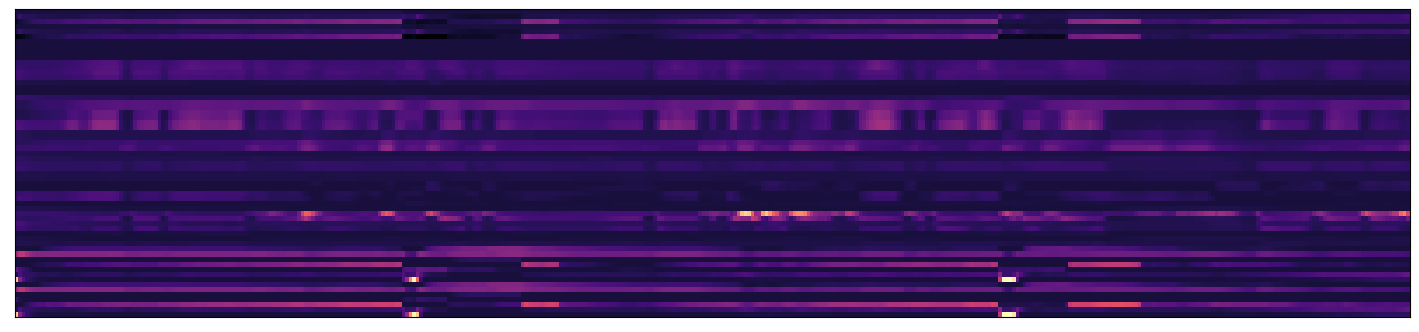

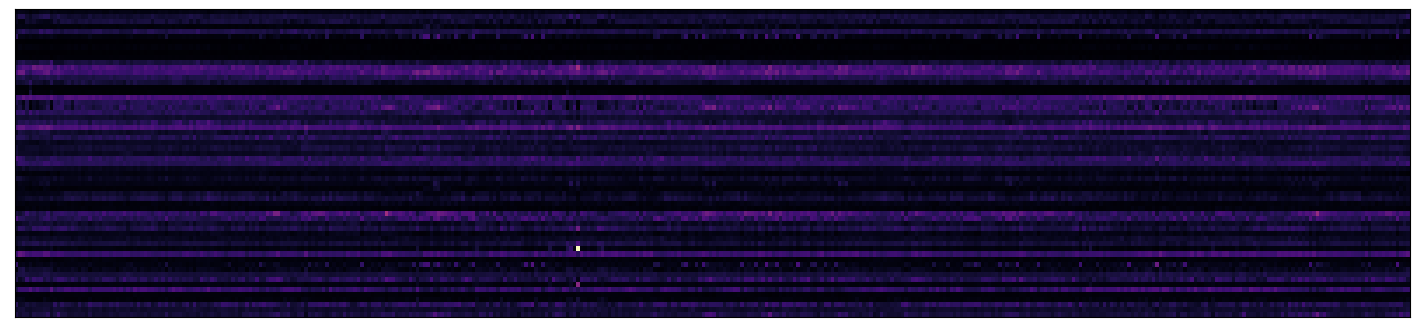

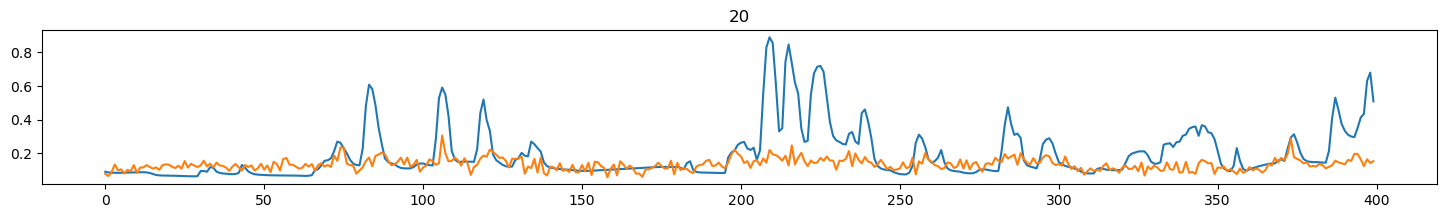

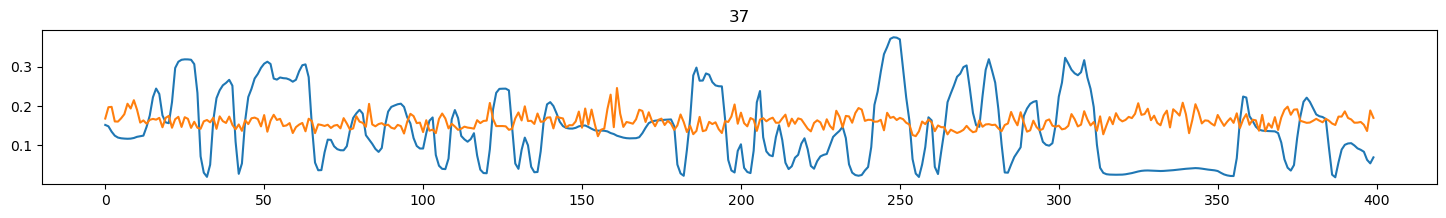

In [16]:
display.clear_output()

losses = []
for i, batch in enumerate(test_loader):
    if i >= 1:
        break

    inputs = torch.Tensor(batch['mel']).transpose(1, 2).to(device)
    targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(logit(targets), inputs)

    loss = 0
    for key in outputs.keys():
        if 'loss' in key:
            loss += outputs[key]
    print('test :', i, loss.item())
    losses.append(loss)        

test_loss = torch.stack(losses).mean().item()
print('test_loss :', test_loss)
writer.add_scalar('test_loss', test_loss, step)

plt.figure(figsize=[18, 4])
librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
plt.show()

model.eval()
with torch.no_grad():
    y_pred = model.inference(inputs)
    y_pred = delogit(y_pred)

plt.figure(figsize=[18, 4])
librosa.display.specshow(y_pred[0].data.cpu().numpy(), cmap='magma')
plt.show()

for i in [20, 37]:
    plt.figure(figsize=[18, 2])
    plt.title(str(i))
    plt.plot(targets[0].data.cpu().numpy()[i])
    plt.plot(y_pred[0].data.cpu().numpy()[i])
    plt.show()